In [91]:
from importlib import reload
import COVID19 as cov
reload(cov)

<module 'COVID19' from '/home/yanbo/Research/COVID19/covid19_domestic_or_import/COVID19.py'>

2260-12-30

226 226


206 202
248 247
Bouvet Island
QuantityMagnitude[Missing["NoResidentPopulation"]]
second
These countries have no pop data:
2020-12-30

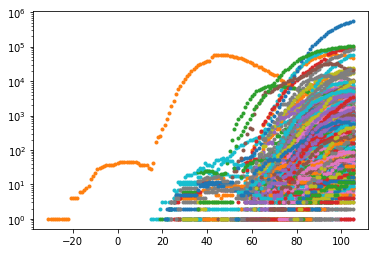

In [34]:
covmodel = cov.COVID19()

# 导入已有数据

In [92]:
covmodel = cov.COVID19(loadpath='auto')
covmodel.loadfit()
covmodel.simulate()

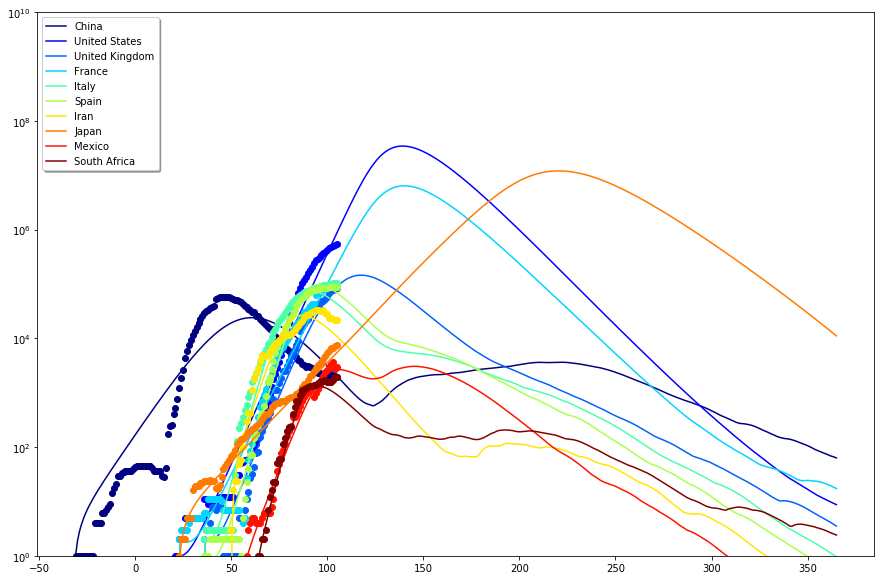

In [93]:
covmodel.plot_simulation()